In [3]:
!pip install --pre deepchem[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 693 kB 6.0 MB/s 
     |████████████████████████████████| 29.3 MB 6.8 MB/s 
     |████████████████████████████████| 1.1 MB 27.5 MB/s 


In [4]:
import deepchem as dc
dc.__version__

'2.7.1'

DeepChem's [lipophilicty data set](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#lipo-datasets) contains measured [logD](https://www.cambridgemedchemconsulting.com/resources/physiochem/logD.html) values for 4200 compounds. [Lipophilicty](https://en.wikipedia.org/wiki/Lipophilicity) measures how well a compound dissolves in non-polar media such as fats and lipids. So it's important for drugs that are delivered orally (for example, via a pill) because the active ingredient [needs to be absorbed into the lipids](https://emerypharma.com/blog/drug-lipophilicity-and-absorption-a-continuous-challenge-toward-the-goal-of-drug-discovery/) of biological membranes.

For this data set, we [split by scaffold](https://deepchem.readthedocs.io/en/latest/api_reference/splitters.html#scaffoldsplitter) the 4200 compounds based on the [Bemis-Murcko scaffold representation](https://pubs.acs.org/doi/10.1021/jm9602928). Such splitting groups molecules based on their scaffolds (core structure) to [prevent train and test from having very similar molecules](httphttps://github.com/deepchem/deepchem/blob/master/examples/tutorials/Working_With_Splitters.ipynb), which could lead to the model appearing to perform well on the test set, but then performing poorly on less-similar molecules in production.

In [5]:
tasks, datasets, transformers = dc.molnet.load_lipo(featurizer='GraphConv', splitter='Scaffold')
train_dataset, valid_dataset, test_dataset = datasets

The number of compounds in the train, validate, and test sets is:

In [6]:
splits = (train_dataset.X.shape[0], valid_dataset.X.shape[0], test_dataset.X.shape[0])
splits

(3360, 420, 420)

Which represents an 80:10:10 train:validate:test split

In [7]:
[split / sum(splits) for split in splits]

[0.8, 0.1, 0.1]

Next, we build a model using DeepChem's [graph convolutional network](https://deepchem.readthedocs.io/en/latest/api_reference/models.html). We use the [dropout technique](https://ai-pool.com/a/s/dropout-in-deep-learning) to avoid overfitting.

In [8]:
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

Then we train the model on the train dataset.

In [9]:
model.fit(train_dataset, nb_epoch=10)

/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_14:0", shape=(443,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_13:0", shape=(443, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_17:0", shape=(2774,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model/graph_pool_1/Reshape_16:0", shape=(2774, 64), dtype=float32), dense_s

0.6382771015167237

To check how well the model fits the train and test data, we examine the [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score.

In [10]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.35733596676636736}
Test set score: {'pearson_r2_score': 0.15106334812602742}


As is typical, the score is better on the training set because the model fit itself to that data. By contrast, the test data is new to the model, so it hasn't had a chance to learn about that test data yet.

To get more information about how well the model works, let's fit it to the test data.

In [11]:
lipos = model.predict_on_batch(test_dataset.X)
lipo_list = []
test_lipo_list = []
for molecule, lipo, test_lipo in zip(test_dataset.ids, lipos, test_dataset.y):
    lipo_list += [lipo[0]]
    test_lipo_list += [test_lipo[0]]
print(f"{lipo_list=}")
print(f"{test_lipo_list=}")

lipo_list=[0.3845331, 0.3720408, -0.023484215, 0.531541, 0.77685773, 0.6073245, 0.2681268, 0.3807276, 0.26924998, 1.3168421, -1.1141771, 0.74688554, 1.2404268, 0.117568895, -0.2170724, 1.6985656, 1.1216733, 0.097339496, 0.8866433, 1.0619586, 0.023231909, 0.56239676, -0.6390465, 0.7374431, 0.621522, 0.50421333, 0.64951164, 0.58112335, 0.1416981, 0.94627386, 0.0364978, 0.8179041, -0.36597848, -0.3082065, 0.37811536, 0.9935026, 0.13907911, 0.06857388, -0.14017858, 0.23282218, 0.4666354, 0.91291934, 1.6561587, 0.8330316, -0.85378474, -0.0061901137, 0.9200858, 0.5301647, 0.14645682, 1.5272315, 0.6357204, 0.39473367, 1.2356297, 0.3559063, 0.5527899, 0.17531888, 0.928601, 1.1793733, 0.76913285, 0.397184, 1.0463703, 0.084844604, 0.8360811, 0.38981336, 1.1470077, 0.86523134, -0.06761201, 1.108468, 0.30433506, -0.7181876, 0.2707923, -0.1086918, 0.788031, 0.5218033, 1.0623503, 1.1002233, 0.72287184, 1.1593384, 0.89388514, 0.039959148, 1.0131426, 0.50972897, 0.8086295, 1.5717392, -0.64395314, 0.67

Then we make put the measured and model-predicted results into a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for easy processing.

In [12]:
import pandas as pd
df = pd.DataFrame(list(zip(test_lipo_list, lipo_list)), columns = ["measured", "predicted"])
df

,measured,predicted
0,-1.810832,0.384533
1,0.319651,0.372041
2,-0.192325,-0.023484
3,0.938978,0.531541
4,0.856401,0.776858
...,...,...
415,0.815112,0.797656
416,1.327089,-0.220663
417,-0.175810,0.607605
418,0.071921,0.148455


Now we can use a scatter plot to compare the predicted against measured values. We use the [seaborn statistical data visualization package](https://seaborn.pydata.org/) to easily plot the data.

In [26]:
import numpy as np
[np.min(lipo_list), np.max(lipo_list)]

[-1.1141771, 1.9521598]

In [27]:
_[1] - _[0]

3.0663369

In [28]:
[np.min(test_lipo_list), np.max(test_lipo_list)]

[-2.85955848206494, 1.9299001765826398]

In [29]:
_[1] - _[0]

4.78945865864758

In [13]:
import seaborn

[Text(0.5, 1.0, 'Lipophilicty for test data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n')]

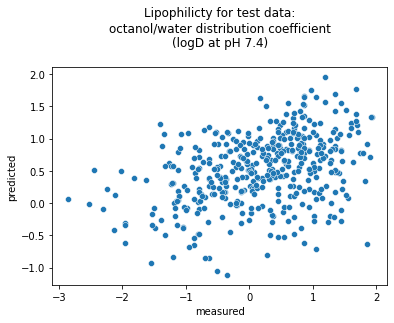

In [14]:
seaborn.scatterplot(data=df, x = "measured", y = "predicted").set(title='Lipophilicty for test data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n')

One observation is that the the measured lipophilicty data have a greater range (about -2.9 to 1.9, comprising 4.8 units) than the predicted results (about -1.1 to 2.0, comprising 3.1 units) by about 1.7 units. This suggests that outliers in the lipophilicty data are not well modeled.

Let's compare to the train data set.

[Text(0.5, 1.0, 'Lipophilicty for train data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n')]

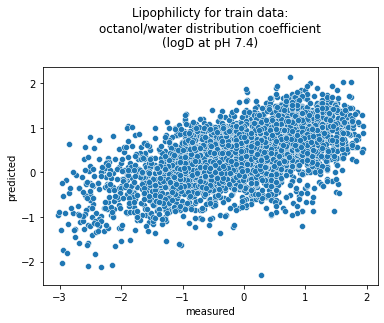

In [15]:
lipos_train = model.predict_on_batch(train_dataset.X)
lipo_list_train = []
test_lipo_list_train = []
for molecule, lipo, test_lipo in zip(train_dataset.ids, lipos_train, train_dataset.y):
    lipo_list_train += [lipo[0]]
    test_lipo_list_train += [test_lipo[0]]
df_train = pd.DataFrame(list(zip(test_lipo_list_train, lipo_list_train)), columns = ["measured", "predicted"])
seaborn.scatterplot(data=df_train, x = "measured", y = "predicted").set(title='Lipophilicty for train data:\noctanol/water distribution coefficient\n(logD at pH 7.4)\n')

In [18]:
import numpy as np
[np.min(lipo_list_train), np.max(lipo_list_train)]

[-2.2968836, 2.1289487]

In [22]:
_[1] - _[0]

4.78945865864758

In [24]:
[np.min(test_lipo_list_train), np.max(test_lipo_list_train)]

[-3.0247122289148565, 1.9299001765826398]

In [25]:
_[1] - _[0]

4.954612405497496

The train data also has a wider measured range (about -3.0 to 1.9, comprising 5.0 units) than predicted (about -2.3 to 2.1, comprising 4.8 units) by about 0.2 units, though the difference in ranges is quite a bit less than the 1.7 units differential for the test data.

While the range differential seems like a minor factor in the train set, we might want to change how we featurize the data to capture a wider range of molecular characteristics. We used the [`GraphConv`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#graph-convolution-featurizers) featurizer, which represents only the *atoms* in a molecule. We might consider the [`WeaveFeaturizer`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html#weavefeaturizer) which also represents the bonds, though it requires more resources.

Perhaps a bigger factor is as follows. We note that both the [Pearson correlation coefficient](https://www.scribbr.com/statistics/pearson-correlation-coefficient/) score is worse, and the range differential is so much greater, for the test data than for the train data. One reason might be that our train set might not have molecules similar to those in the test set. Recall that we split by scaffold, so it's possible that splitting led to compounds in the test set that have scaffolds significantly different from those in the train set. Adding compounds to the dataset so that there is less "scaffold distance" (difference in scaffold structure) between groups of compounds might help.

To take a simple hypothetical example, if we had a dataset with compounds containing either one or three rings, the scaffold splitting might put all the one-ring compounds in the train set and all the three-ring compounds in the test set. We expect that would lead to poor predictions on the test set. We would want to augment the dataset by adding compounds containing two rings.

This blog post was based on the DeepChem tutorial [The Basic Tools of the Deep Life Sciences](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/The_Basic_Tools_of_the_Deep_Life_Sciences.ipynb).